# COMP5331 Group 6 Project: Resilient k-Clustering

In [2]:
%load_ext autoreload
%autoreload 2

## Mount Drive

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/Colab Notebooks/Comp 5331/"
%ls

## Preprocess datasets

In [ ]:
from src.preprocess.process_uber import process_uber
ds_path = "dataset/uber/uber-raw-data-jun14.csv"
save_path = "dataset/uber/"
process_uber(ds_path, save_path)

In [ ]:
from src.preprocess.process_geo import process_geo
ds_names = ["Brightkite", "Gowalla"]
for ds_name in ds_names:
    ds_path = f"/dataset/snap_standford/{ds_name}_totalCheckins.txt"
    save_path = "/dataset/snap_standford/"
    process_geo(ds_path, save_path, ds_name)

## Testing

In [9]:
import numpy as np
from src.resilient_k import resilient_k_center
from src.datasets import *
from os.path import join
from src.testing.plot_cluster_result import plot_cluster_result
import pickle

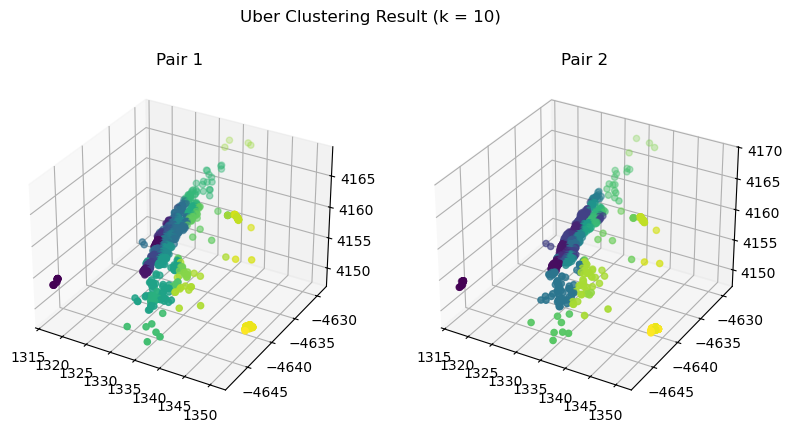

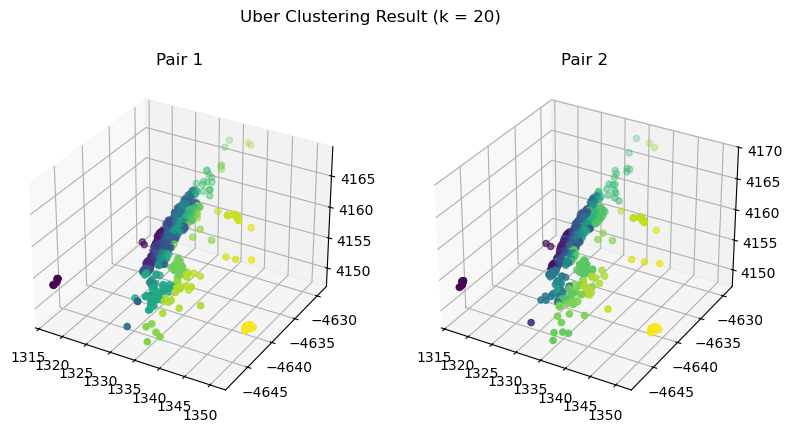

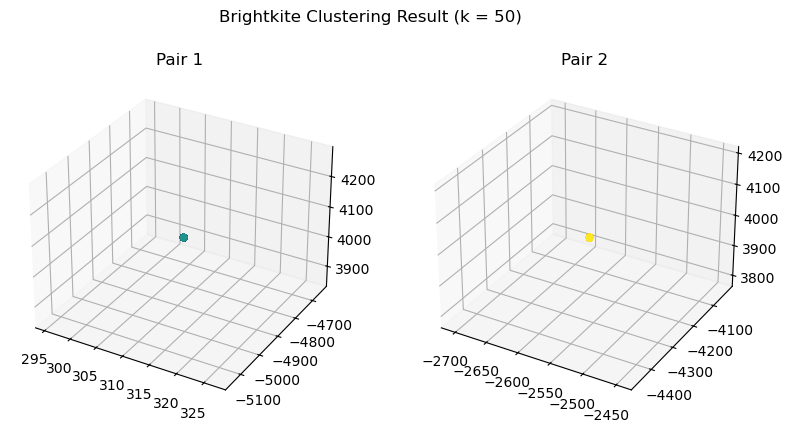

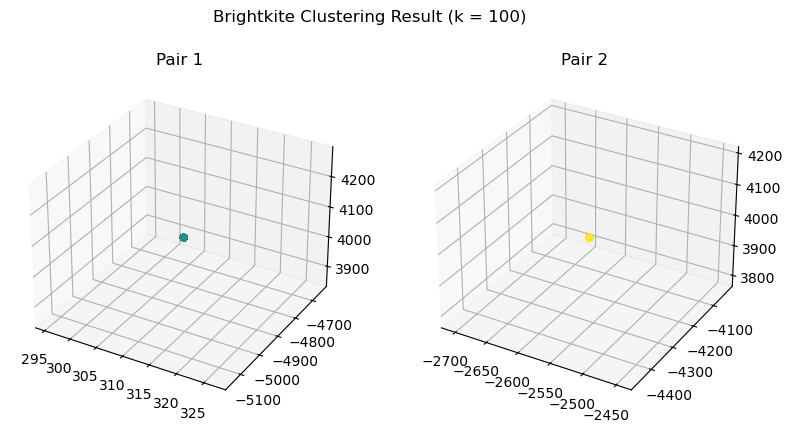

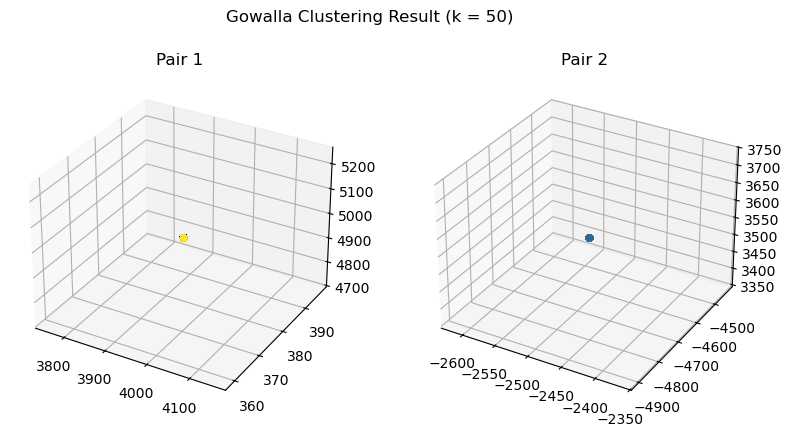

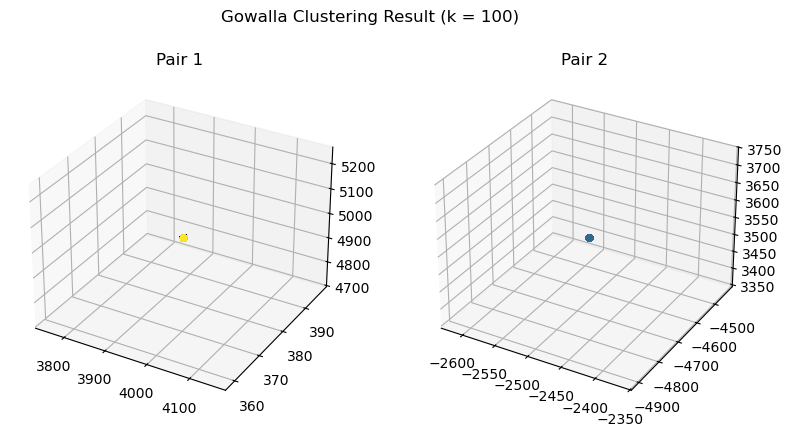

In [14]:
ds_path = "./dataset"
dataset = [Uber(join(ds_path, "uber/uber_epsilon.csv"), lamb=1.1, k=10),
           Uber(join(ds_path, "uber/uber_epsilon.csv"), lamb=1.1, k=20),
           Geo(join(ds_path, "snap_standford/Brightkite_epsilon.csv"), "Brightkite", lamb=1.1, k=50), 
           Geo(join(ds_path, "snap_standford/Brightkite_epsilon.csv"), "Brightkite", lamb=1.1, k=100),
           Geo(join(ds_path, "snap_standford/Gowalla_epsilon.csv"), "Gowalla", lamb=1.001, k=50),
           Geo(join(ds_path, "snap_standford/Gowalla_epsilon.csv"), "Gowalla", lamb=1.001, k=100)]
plot_path = "./results/plot"
result_path = "./results"

for ds in dataset:
    pair1, pair2 = ds.load()
    epsilon = 0.3
    model1 = resilient_k_center(pair1, k=ds.k, lamb=ds.lamb, epsilon=epsilon)
    center1, cluster1 = model1.resilient_k_center()
    model2 = resilient_k_center(pair2, k=ds.k, lamb=ds.lamb, epsilon=epsilon)
    center2, cluster2 = model2.resilient_k_center()
    
    with open(join(result_path, f"{ds.name}_resilient_{ds.k}.pickle"), 'wb') as output_file:
        pickle.dump((center1, cluster1, center2, cluster2), output_file)
        
    pt1 = np.asarray([c[0] for c in cluster1])
    pt2 = np.asarray([c[0] for c in cluster2])
    label1 = [c[1] for c in cluster1]
    label2 = [c[1] for c in cluster2]
    plot_cluster_result(pt1, pt2, label1, label2, plot_path, ds)
        

## Evalutaion

In [1]:
from src.evaluation import Metrics

In [ ]:
# to_eval = {"Uber": [10, 20],
#  "Gowalla": [50, 100],
#  "Brightkite": [50, 100]}
to_eval = [Uber(join(ds_path, "uber/uber_epsilon.csv"), lamb=1.1, k=10),
           Uber(join(ds_path, "uber/uber_epsilon.csv"), lamb=1.1, k=20),
           Geo(join(ds_path, "snap_standford/Brightkite_epsilon.csv"), "Brightkite", lamb=1.1, k=50), 
           Geo(join(ds_path, "snap_standford/Brightkite_epsilon.csv"), "Brightkite", lamb=1.1, k=100),
           Geo(join(ds_path, "snap_standford/Gowalla_epsilon.csv"), "Gowalla", lamb=1.001, k=50),
           Geo(join(ds_path, "snap_standford/Gowalla_epsilon.csv"), "Gowalla", lamb=1.001, k=100)]
result_path = "./results"

for ds, ks in to_eval.items():
    for k in ks:
        
        with open(join(result_path, f"{ds}_resilient_{k}.pickle"), 'rb') as input_file:
            center1, cluster1, center2, cluster2 = pickle.load((center1, cluster1, center2, cluster2), input_file)
        
        points = [c[0] for c in cluster1] + [c[0] for c in cluster2]
        old_cluster = cluster1
        new_cluster = cluster2
        
        
        metric = Metrics().evaluate(points, old_cluster, new_cluster)